In [2]:
%reload_ext autoreload
%autoreload 2

import sys
sys.path.append('../')
from tsdr import tsdr
from tsdr.testseries import sockshop

import numpy as np
import matplotlib.pyplot as plt
import scipy.stats

# KPSS test

/home/ubuntu/src/github.com/ai4sre/meltria-analyzer/.venv/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
/home/ubuntu/src/github.com/ai4sre/meltria-analyzer/.venv/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
/home/ubuntu/src/github.com/ai4sre/meltria-analyzer/.venv/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
/home/ubuntu/src/github.com/ai4sre/meltria-analyzer/.venv/lib/python3.9/site-packages

c-orders_network_receive_packets:White noise 0.1 4
c-orders-db_network_transmit_bytes_total:White noise 0.08844775903620662 6
c-catalogue_last_seen:Trend increase 0.1 14
s-front-end_throughput:Noise autocorrection 0.01880199944068715 6
c-user_memory_usage_bytes:Slight change 0.08632129989391754 6
s-shipping_throughput:Autocorrect 0.1 5
c-orders_memory_usage_bytes:Sudden increase 0.01 6
s-front-end_latency:Level shift up 0.01 6
c-user_memory_working_set_bytes:Level shift up 0.01 6
c-front-end_memory_usage_bytes:Level shift down 0.01 6
s-user_latency:Single spike 0.1 5
s-orders_latency:Single spike 0.1 5
c-carts-db_memory_failures_total:Single spike 0.1 3
s-front-end_latency:Transient level shift up 0.02896227098440727 6
s-orders_latency02:Transient level shift up 0.08612033523497573 6
c-catalogue_cpu_cfs_throttled_periods_total:Multiple spikes 0.1 4
c-user_cpu_usage_seconds_total:White noise -> Transient level shift down 0.01 5
c-front-end_network_receive_packets_total:White noise -> Tr

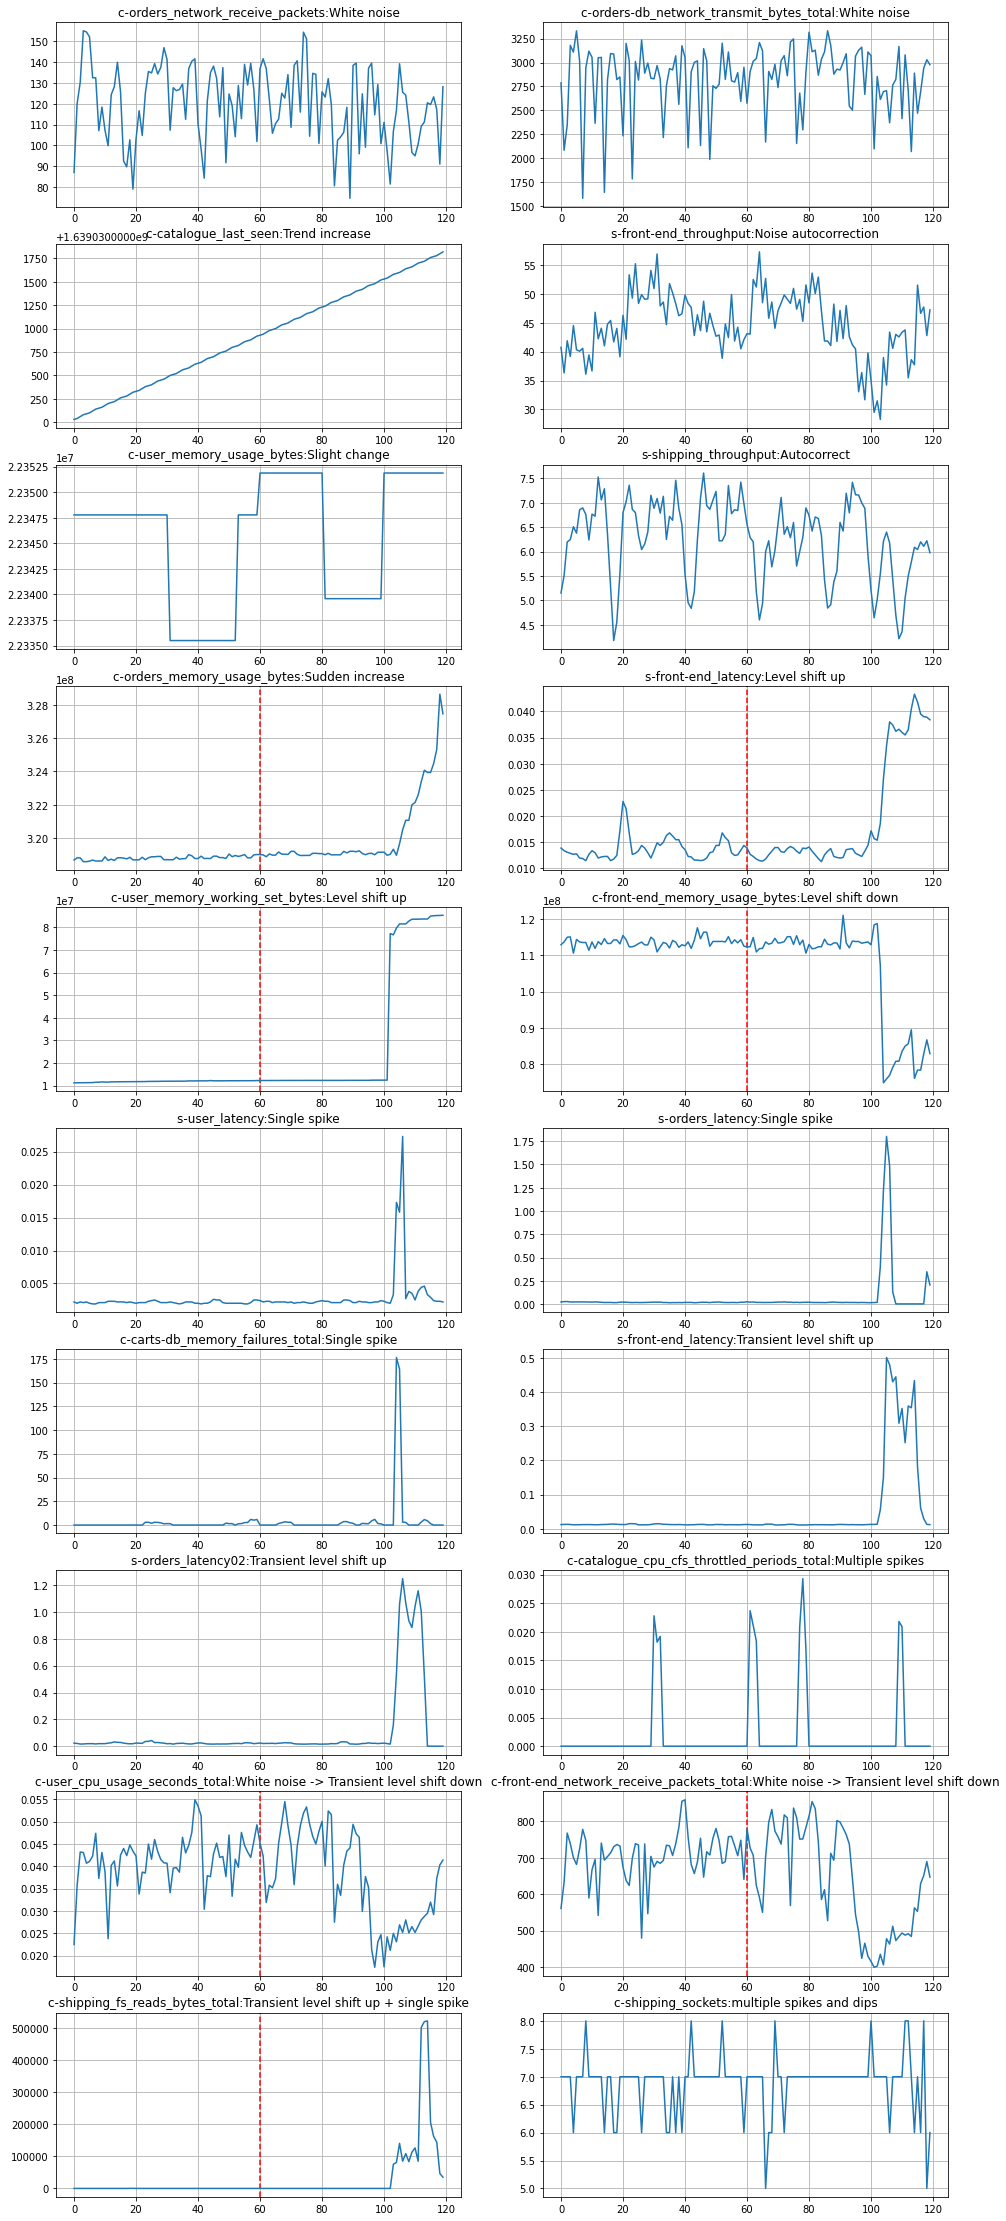

In [3]:
from statsmodels.tsa.stattools import kpss

cases = sockshop.testcases_of_sockshop
fig, axs = plt.subplots(len(cases)//2, ncols=2)
fig.set_size_inches(16, 2*len(cases))
for case, ax in zip(cases, axs.flatten()):
    ts = np.array(case['datapoints'])
    # ts = tsdr.smooth_with_ma(np.array(case['datapoints']))
    stat, p_value, lags, _ = kpss(ts, regression='ct') 
    if p_value <= 0.01:
        ax.axvline(ts.size//2, color='red', linestyle='dashed', label='breaks')
    print(f"{case['name']}:{case['pattern']}", p_value, lags)

    ax.set_title(f"{case['name']}:{case['pattern']}")
    ax.plot(ts)
    ax.grid()

# Robust z-score + KPSS test

In [4]:
from sklearn.preprocessing import robust_scale

def robust_zscore_3sigma_rule(ts: np.ndarray, sigma=3):
    zscores = robust_scale(ts)
    mean = np.mean(zscores)
    std = np.std(zscores)
    outliers = []
    for i, z in enumerate(zscores):
        if abs(z - mean) > sigma * std:
            outliers.append((i, z))
    return outliers

/home/ubuntu/src/github.com/ai4sre/meltria-analyzer/.venv/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
/home/ubuntu/src/github.com/ai4sre/meltria-analyzer/.venv/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
/home/ubuntu/src/github.com/ai4sre/meltria-analyzer/.venv/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
/home/ubuntu/src/github.com/ai4sre/meltria-analyzer/.venv/lib/python3.9/site-packages

c-orders_network_receive_packets:White noise 0.1 4
c-catalogue_last_seen:Trend increase 0.1 14
s-front-end_throughput:Noise autocorrection 0.01880199944068715 6
c-user_memory_usage_bytes:Slight change 0.08632129989391754 6
s-shipping_throughput:Autocorrect 0.1 5
c-user_memory_working_set_bytes:Level shift up 0.01 6
c-user_cpu_usage_seconds_total:White noise -> Transient level shift down 0.01 5
c-front-end_network_receive_packets_total:White noise -> Transient level shift down 0.01 5


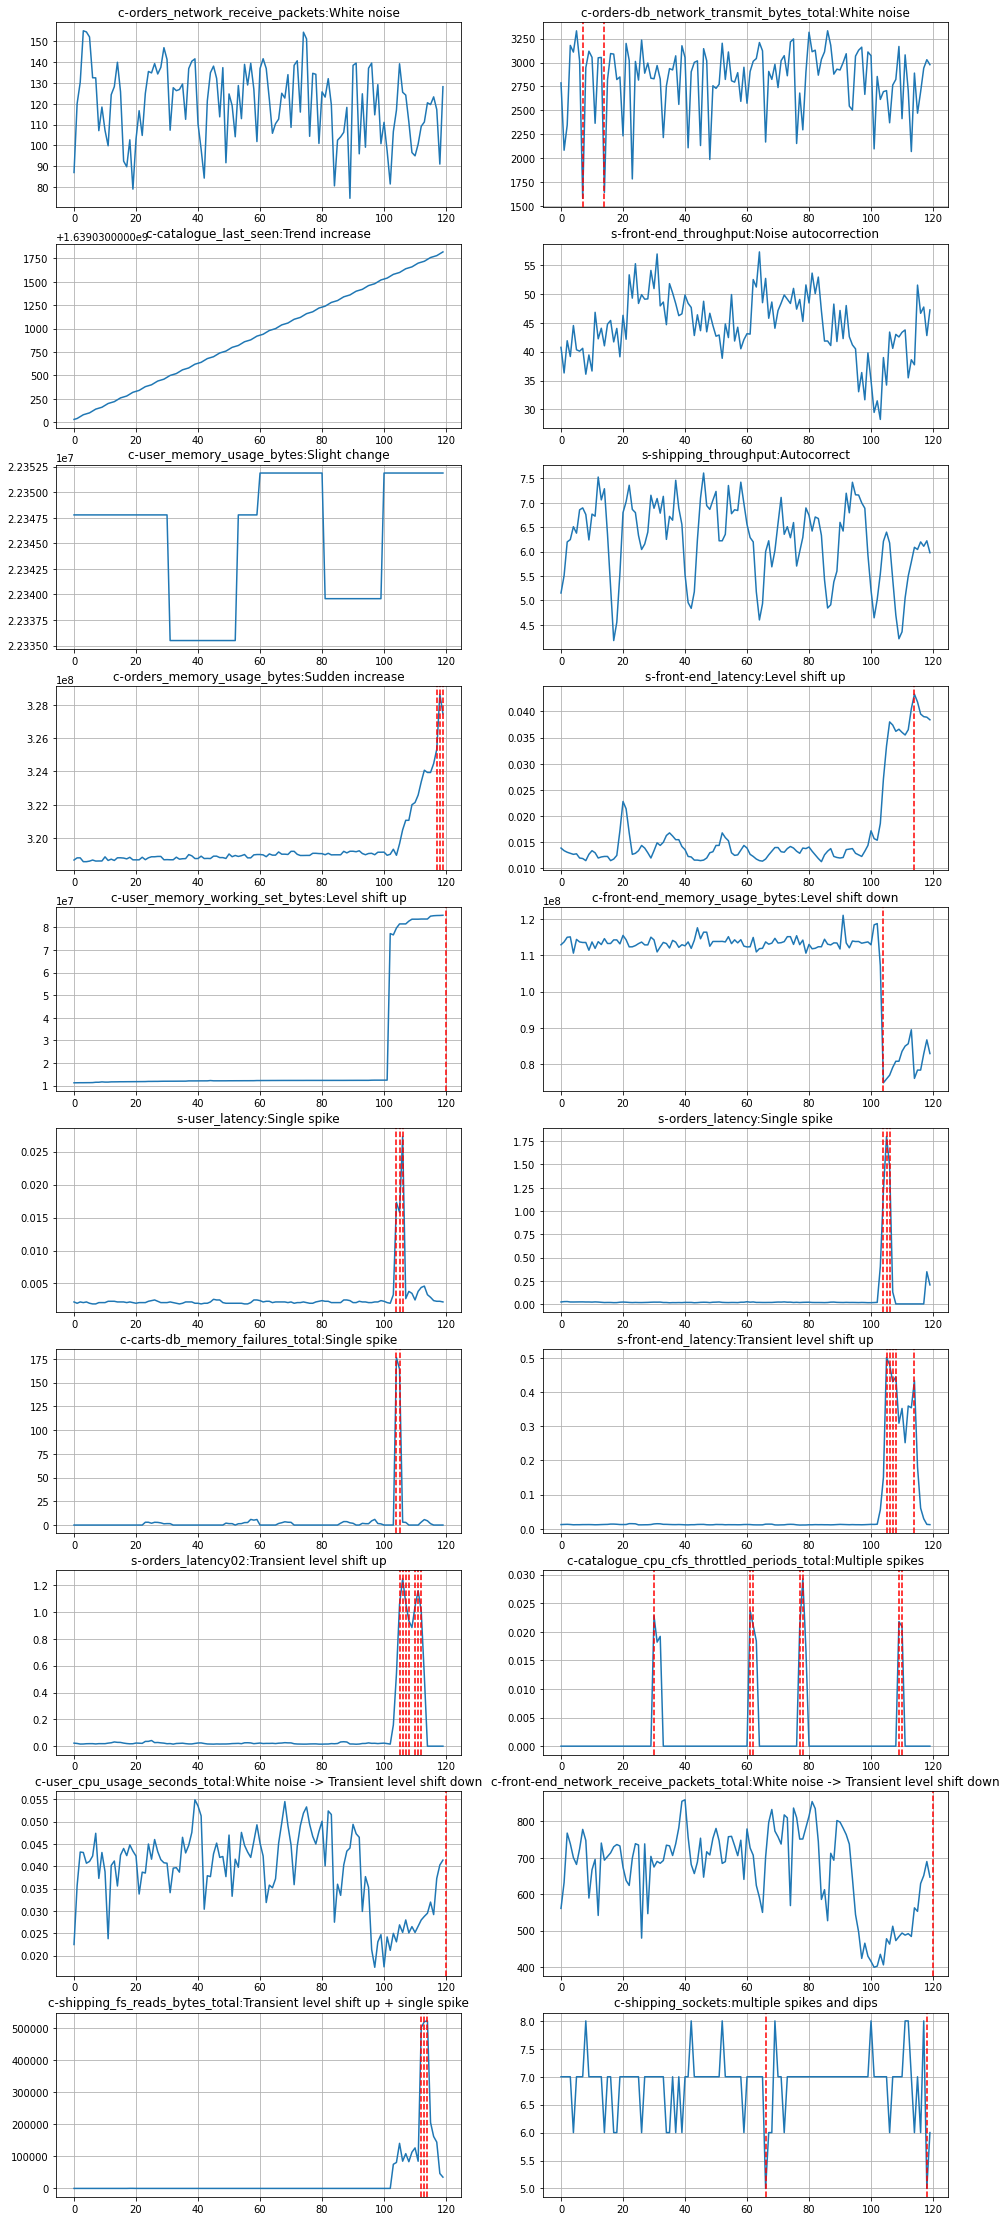

In [6]:
import math

cases = sockshop.testcases_of_sockshop
fig, axs = plt.subplots(math.ceil(len(cases)//2), ncols=2)
fig.set_size_inches(16, 2*len(cases))
for case, ax in zip(cases, axs.flatten()):
    ts = np.array(case['datapoints'])
    ax.set_title(case['name'] + ':' + case['pattern'])
    ax.plot(ts)
    ax.grid()
    # ts = tsdr.smooth_with_ma(np.array(case['datapoints']))
    outliers = robust_zscore_3sigma_rule(ts, sigma=3)
    if len(outliers) > 0:
        for outlier in outliers:
            ax.axvline(outlier[0], color='red', linestyle='dashed', label='breaks')
        continue

    stat, p_value, lags, _ = kpss(ts, regression='ct') 
    if p_value <= 0.01:
        ax.axvline(ts.size, color='red', linestyle='dashed', label='breaks')
    print(f"{case['name']}:{case['pattern']}", p_value, lags)

In [7]:
# OLS + z-score 3sigma

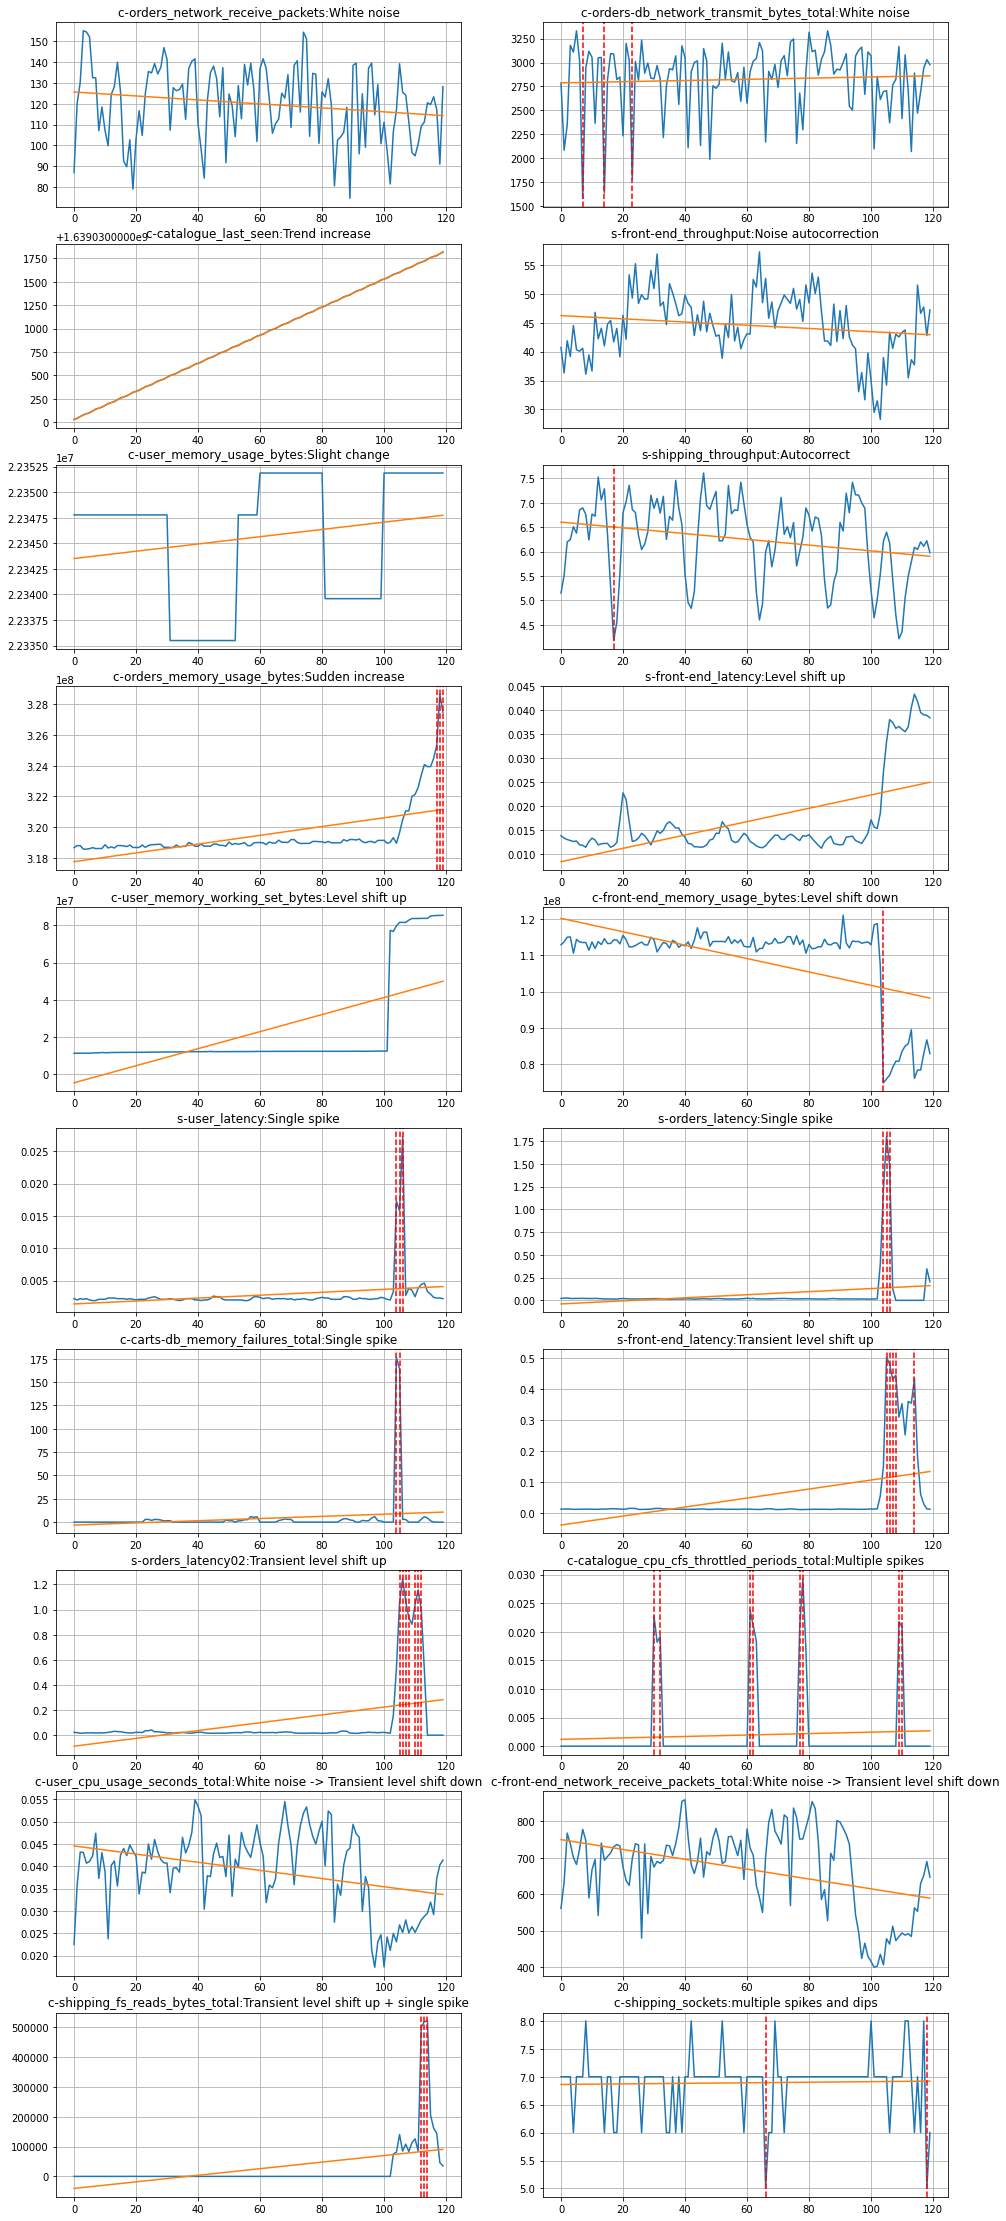

In [8]:
import math
from statsmodels.regression.linear_model import OLS
from statsmodels.tools.tools import add_constant
import banpei

cases = sockshop.testcases_of_sockshop
fig, axs = plt.subplots(math.ceil(len(cases)//2), ncols=2)
fig.set_size_inches(16, 2*len(cases))
for case, ax in zip(cases, axs.flatten()):
    ts = np.array(case['datapoints'])
    ax.set_title(case['name'] + ':' + case['pattern'])
    ax.plot(ts)
    ax.grid()

    ols_fit = OLS(ts, add_constant(np.arange(1, ts.size + 1))).fit()
    ax.plot(ols_fit.predict())
    resids = ols_fit.resid
    # resids = ts - ts.mean()
    # ts = tsdr.smooth_with_ma(np.array(case['datapoints']))
    outliers = banpei.Hotelling().detect(resids, threshold=0.01)
    # outliers = robust_zscore_3sigma_rule(resids, sigma=3)
    if len(outliers) > 0:
        for outlier in outliers:
            ax.axvline(outlier[0], color='red', linestyle='dashed', label='breaks')

    # stat, p_value, lags, _ = kpss(ts, regression='ct') 
    # if p_value <= 0.01:
    #     ax.axvline(ts.size, color='red', linestyle='dashed', label='breaks')
    # print(f"{case['name']}:{case['pattern']}", p_value, lags)

## AR model + KPSS test

In [ ]:
from tsdr.outlierdetection.ar import AROutlierDetector

import math
from statsmodels.tsa.stattools import kpss

cases = sockshop.testcases_of_sockshop
fig, axs = plt.subplots(math.ceil(len(cases)//2), ncols=2)
fig.set_size_inches(16, 2*len(cases))
for case, ax in zip(cases, axs.flatten()):
    ts = np.array(case['datapoints'])
    ax.set_title(case['name'] + ':' + case['pattern'])
    ax.plot(ts)
    ax.grid()

    ar = AROutlierDetector(ts)
    ar.fit(regression='n', ic='bic')
    ax.plot([np.nan] * ar._lag + list(ar.predict_in_sample()[0]))
    # resids = ts - ts.mean()
    # ts = tsdr.smooth_with_ma(np.array(case['datapoints']))
    scores = ar.anomaly_scores_in_sample()
    outliers, _ = ar.detect_by_fitting_dist(scores, threshold=0.01)
    if len(outliers) > 0:
        for outlier in outliers:
            ax.axvline(outlier[0], color='red', linestyle='dashed', label='breaks')

    stat, p_value, lags, _ = kpss(ts, regression='ct') 
    if p_value <= 0.01:
        ax.axvline(ts.size, color='red', linestyle='dashed', label='breaks')
    print(f"{case['name']}:{case['pattern']}", p_value, lags)